Titanic Dataset Model
=====================

Import Libraries
----------------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import re

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

Import Data
-----------

In [3]:
data_path = Path(Path.cwd() / 'Data')

df_train = pd.read_csv(data_path / 'train.csv')
df_test = pd.read_csv(data_path / 'test.csv')
df_gender_sub = pd.read_csv(data_path / 'gender_submission.csv')

list_of_df = [df_train, df_test]
list_of_df_names = ["Train", "Test"]

Build Transformers and Pipeline
-------------------------------

In [4]:
class EmptyValuesRowRemover:
    
    """
    Removes rows which contain Null values for a specific column or columns.
    If there are no columns specified then the transformer will apply to all columns in the dataset.
    """
    
    def __init__(self, columns=[]):
        self.columns = columns
        assert(
            type(columns)==list,
            "Error: This class expects a list of columns names to be passed at initiation."
        )
    
    def Remover(self, X):
        if self.columns == []:
            self.column_list = list(X)
        else:
            self.column_list = self.columns
        self.list_of_bools = []
        for column in self.column_list:
            X = X.loc[X.loc[:,column].notnull()]
        return X

In [5]:
class CabinGrouper:
    
    """
    Groups the cabins into categories based on the first letter in the cabin code.
    If a field is null it is filled with "No Assigned Cabin"
    """
    
    def Grouper(self, X):
        X.Cabin = X.Cabin.str[0]
        X.Cabin = X.Cabin.fillna("No Assigned Cabin")
        return X

In [24]:
class DenseTransformer(BaseEstimator, TransformerMixin):
    
    """
    Custom SK-learn transformer.
    Returns a dense array.
    """

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        X = X.todense()
        return X

In [16]:
class HonorificExtractor(BaseEstimator, TransformerMixin):
    
    """
    Custom SK-learn transformer.
    Extracts honorifics from a string type column and groups them further into:
    Officer, Royalty, Mr, Mrs, Miss, Master.
    NaN is assumed to be Mr.
    """
    
    def __init__(self, column):
        self.column = column
        
    # dictionary to map to generate the new feature vector
    title_dictionary = {
        "capt":"Officer", 
        "col":"Officer", 
        "major":"Officer", 
        "dr":"Officer",
        "jonkheer":"Royalty",
        "rev":"Officer",
        "countess":"Royalty",
        "dona":"Royalty",
        "don":"Royalty",
        "mr":"Mr",
        "mme":"Mrs",
        "ms":"Mrs",
        "mrs":"Mrs",
        "miss":"Miss",
        "mlle":"Miss",
        "master":"Master",
        "nan":"Mr"
    }
    
    def get_title(self, string):
        regex = re.compile(
            r'Mr|Don|Major|Capt|Jonkheer|Rev|Col|Dr|Mrs|Countess|Dona|Mme|Ms|Miss|Mlle|Master', 
            re.IGNORECASE
        )
        results = regex.search(string)
        if results != None:
            return(results.group().lower())
        else:
            return(str(np.nan))
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Title'] = X.loc[:,self.column].apply(self.get_title)
        X['Title'] = X.loc[:,'Title'].map(self.title_dictionary)
        X = X.drop(self.column, axis=1)
        return X

In [17]:
PrePreprocessingPipe = Pipeline(
    steps=[
#         ("evrr", EmptyValuesRowRemover(columns=["Age"])),
        ("he", HonorificExtractor(column="Name"))
    ]
)

In [18]:
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch']
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

In [19]:
categorical_features = ['Embarked', 'Sex', 'Pclass', 'Cabin']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [20]:
PreprocessingPipeline = Pipeline(
    steps=[
        ("pp", PrePreprocessingPipe), 
        ("ct", ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ]
        ))
    ]
)


In [21]:
Model = Pipeline(
    steps=[
        ('pp', PreprocessingPipeline),
        ('classifier', LogisticRegression(solver='lbfgs'))
    ]
)

for df in [df_train, df_test]:
    df = EmptyValuesRowRemover(columns=["Age"]).Remover(df)
    df = CabinGrouper().Grouper(df)
    
print(df_train.shape, df_test.shape)

X_train = df_train.drop('Survived', axis='columns')
X_test = df_test
y_train = df_train.loc[:,'Survived']

print(X_train.shape, X_test.shape, y_train.shape)

Model.fit(X_train, y_train.values.ravel())
y_predict = Model.predict(X_test)
df_results = pd.DataFrame({"PassengerId": X_test.PassengerId, "Survived": y_predict})
df_results.to_csv("submission_NEW.csv", index=False)

(891, 12) (418, 12)
(891, 11) (418, 12) (891,)


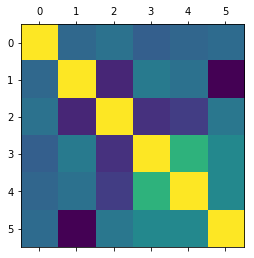

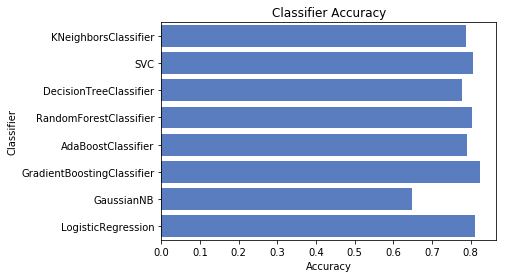

In [30]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True, gamma='scale'),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
#     LinearDiscriminantAnalysis(),
#     QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='lbfgs')
]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

acc_dict = {}

for train_index, test_index in sss.split(X_train.values, y_train.values): 
    Xtrain, Xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    ytrain, ytest = y_train.iloc[train_index], y_train.iloc[test_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        Model = Pipeline(
            steps=[
                ('pp', PreprocessingPipeline),
                ('to_dense', DenseTransformer()),
                ('classifier', clf)
            ]
        )
        Model.fit(Xtrain, ytrain)
        train_predictions = Model.predict(Xtest)
        acc = accuracy_score(ytest, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc
            
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)
    
plt.matshow(Xtrain.corr())
plt.show()

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
plt.show()